In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import datetime
import gc
import random
import re
import operator

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import f1_score,precision_score,recall_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.optimizer import Optimizer

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['quora-insincere-questions-classification', 'phemerumour']


In [2]:
##reading the csv file of ta-rumour
phemestance=pd.read_csv('../input/phemerumour/pheme-rumour.csv')

In [3]:
phemestance.head()

,Topic,SourceTweet,ReplyTweet,Label
0,sydneysiege,"""My fellow Australians. Let's stand together a...","""@roamingaussie\nWhat an imbecile joker? You i...",non-rumours
1,sydneysiege,"""My fellow Australians. Let's stand together a...","""@alfroz agreed, but what about the hatred of ...",non-rumours
2,sydneysiege,"""My fellow Australians. Let's stand together a...","""@alfroz the only good Muslim is a dead muslim""",non-rumours
3,sydneysiege,"""My fellow Australians. Let's stand together a...","""@alfroz Never heard of that beast, innocent M...",non-rumours
4,sydneysiege,"""My fellow Australians. Let's stand together a...","""@alfroz who is the Brother ,afroz?""",non-rumours


In [4]:
##glove embeddings text file
glove='../input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt';

In [5]:
## returns a dict of words and their embeddings in an array
def glove_dict(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [6]:
%%time
glove_embeddings_dict=glove_dict(glove)

CPU times: user 2min 30s, sys: 6.42 s, total: 2min 37s
Wall time: 2min 37s


In [7]:
print("Number of embeddings loaded",len(glove_embeddings_dict))

Number of embeddings loaded 2196016


In [8]:
##removing quoatations 
phemestance['SourceTweet']=phemestance['SourceTweet'].apply(lambda x:x[1:len(x) - 1])
phemestance['ReplyTweet']=phemestance['ReplyTweet'].apply(lambda x:x[1:len(x) - 1])
print(phemestance.shape)
phemestance.head()

(97410, 4)


,Topic,SourceTweet,ReplyTweet,Label
0,sydneysiege,My fellow Australians. Let's stand together ag...,@roamingaussie\nWhat an imbecile joker? You id...,non-rumours
1,sydneysiege,My fellow Australians. Let's stand together ag...,"@alfroz agreed, but what about the hatred of i...",non-rumours
2,sydneysiege,My fellow Australians. Let's stand together ag...,@alfroz the only good Muslim is a dead muslim,non-rumours
3,sydneysiege,My fellow Australians. Let's stand together ag...,"@alfroz Never heard of that beast, innocent Mu...",non-rumours
4,sydneysiege,My fellow Australians. Let's stand together ag...,"@alfroz who is the Brother ,afroz?",non-rumours


In [9]:
##converting to lower strings
phemestance['SourceTweet']=phemestance['SourceTweet'].apply(lambda x:x.lower())
phemestance['ReplyTweet']=phemestance['ReplyTweet'].apply(lambda x:x.lower())
print(phemestance.shape)
phemestance.head()

(97410, 4)


,Topic,SourceTweet,ReplyTweet,Label
0,sydneysiege,my fellow australians. let's stand together ag...,@roamingaussie\nwhat an imbecile joker? you id...,non-rumours
1,sydneysiege,my fellow australians. let's stand together ag...,"@alfroz agreed, but what about the hatred of i...",non-rumours
2,sydneysiege,my fellow australians. let's stand together ag...,@alfroz the only good muslim is a dead muslim,non-rumours
3,sydneysiege,my fellow australians. let's stand together ag...,"@alfroz never heard of that beast, innocent mu...",non-rumours
4,sydneysiege,my fellow australians. let's stand together ag...,"@alfroz who is the brother ,afroz?",non-rumours


In [10]:
##getting the num of words in each sentence
phemestance['Num_words_src']=phemestance['SourceTweet'].apply(lambda x:len(x.split()))
phemestance['Num_words_reply']=phemestance['ReplyTweet'].apply(lambda x:len(x.split()))
print(phemestance.shape)
phemestance.head()

(97410, 6)


,Topic,SourceTweet,ReplyTweet,Label,Num_words_src,Num_words_reply
0,sydneysiege,my fellow australians. let's stand together ag...,@roamingaussie\nwhat an imbecile joker? you id...,non-rumours,18,23
1,sydneysiege,my fellow australians. let's stand together ag...,"@alfroz agreed, but what about the hatred of i...",non-rumours,18,11
2,sydneysiege,my fellow australians. let's stand together ag...,@alfroz the only good muslim is a dead muslim,non-rumours,18,9
3,sydneysiege,my fellow australians. let's stand together ag...,"@alfroz never heard of that beast, innocent mu...",non-rumours,18,8
4,sydneysiege,my fellow australians. let's stand together ag...,"@alfroz who is the brother ,afroz?",non-rumours,18,6


In [11]:
print("The average word length in src_tweet is",phemestance['Num_words_src'].mean(),
                      "and in reply_tweet is",phemestance['Num_words_reply'].mean())

The average word length in src_tweet is 16.585093932861103 and in reply_tweet is 14.001262704034493


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


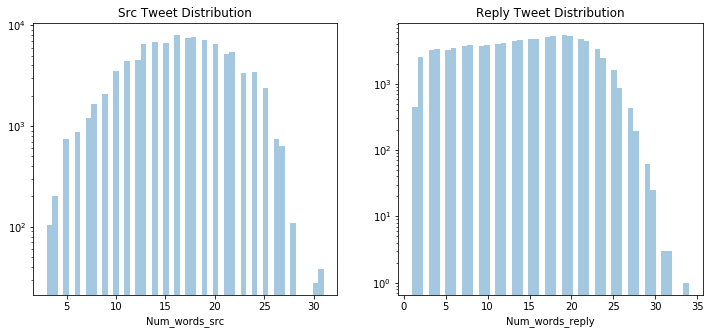

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(phemestance['Num_words_src'],kde=False)
plt.yscale("log")
plt.title("Src Tweet Distribution")
plt.subplot(122)
sns.distplot(phemestance['Num_words_reply'],kde=False)
plt.yscale("log")
plt.title("Reply Tweet Distribution")
plt.show()

In [13]:
## handling punctuations
phemestance['SourceTweet']=phemestance['SourceTweet'].apply(lambda x:x.replace("’","'"))
phemestance['ReplyTweet']=phemestance['ReplyTweet'].apply(lambda x:x.replace("’","'"))

In [14]:
import string
PUNC = string.punctuation.replace('@',"")
PUNC = PUNC+"”“‘‘"
url = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+] |[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

In [15]:
contraction_mapping={"haven't":"have not","hadn't":"had not","wasn't":"was not","he's":"he is",
                     "couldn't":"could not","she's":"she is","i'm":"i am","we've":"we have",
                     "wouldn't":"would not","that's":"that is","we're":"we are","isn't":"is not",
                     "hasn't":"has not","they're":"they are","she's":"she is","he's":"he is","weren't":"were not",
                    "there's":"there is","i've":"i have","you've":"you have","we've":"we have","we'd":"we would",
                    "we're":"we are","who's":"who is","they'll":"they will","what's":"what is","she'd":"she would",
                    "aren't":"are not","shouldn't":"should not","There's":"There is",
                     "we'll":"we will","I`m":"I am","you're":"you are","i'd":"i would","he'll":"he will",
                    "they'd":"they would","didn't":"did not","you'll":"you will",
                    "would've":"would have","you\'re":"you are","i'll":"i will",
                    "film/theater":"film or theater","that\'s":"that is","we'd":"we would",
                    "they've":"they have","she'll":"she will","haven't":"have not","it'll":"it will","you'd":"you would",
                    "i've":"i have","i`ve":"i have","she'll":"she will","it'll":"it will","hadn't":"had not","i\'ve":"i have",
                     "you\'re":"you are","b'day":"birthday","don't":"do not","it'd":"it would","you've":"you have",
                    "don\'t":"do not","what\'s":"what is","won't":"will not",
                    "he'd":"he would","don't":"do not","here's":"here is","i'll":"i will","let's": "let us",
                    "i'd":"i had","when's": "when is","y'all":"you all","it's":"it is","can't":"cannot","what's":"what is",
                    "where's":"where is","ain't":"are not","let´s":"let us","gov't":"government","could've":"could have"}
def replace_contraction_mapping(x):
    for contract in contraction_mapping.keys():
        x=x.replace(contract,contraction_mapping[contract])
    return x
def stripof(x):
    out = ''
    for word in x.split():
        if not url.search(word) and word[0]!='@':
            word= word.strip(PUNC)
            out+=re.sub("\'s$", "", word)+' '
    return out
phemestance['SourceTweet']=phemestance['SourceTweet'].apply(lambda x:stripof(x))
phemestance['ReplyTweet']=phemestance['ReplyTweet'].apply(lambda x:stripof(x))
phemestance['SourceTweet']=phemestance['SourceTweet'].apply(lambda x:replace_contraction_mapping(x))
phemestance['ReplyTweet']=phemestance['ReplyTweet'].apply(lambda x:replace_contraction_mapping(x))
src_tweet_cleaned = phemestance['SourceTweet']
reply_tweet_cleaned = phemestance['ReplyTweet']


In [16]:
# src_tweet_cleaned

In [17]:

tweets=pd.concat([src_tweet_cleaned,reply_tweet_cleaned])


In [18]:
# tweets

In [19]:
# print(src_tweet_cleaned)
# print(reply_tweet_cleaned)
# print(tweets)

In [20]:
# phemestance['SourceTweet'].head()
# phemestance['ReplyTweet'].head()
# phemestance.head()

In [21]:
def sen(x):
    return x.split()
src_sentences=src_tweet_cleaned.apply(sen)
reply_sentences=reply_tweet_cleaned.apply(sen)
tweet_sentences=tweets.apply(sen)

In [22]:
# src_sentences
# reply_sentences
# tweet_sentences

In [23]:
def build_vocab(sentences,verbose=True):
    vocab={}
    for sentence in tqdm(sentences,disable=(not verbose)):
        for word in sentence:
#             word = word.lower()
#             word = word.strip(PUNC)
#             word = re.sub("\'s$", "", word)
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
                
    print("Number of words found in vocab are",len(vocab.keys()))
    return dict(sorted(vocab.items(), key=operator.itemgetter(1))[::-1])
src_vocab=build_vocab(src_sentences)
reply_vocab=build_vocab(reply_sentences)
tweet_vocab=build_vocab(tweet_sentences)

 31%|███       | 30326/97410 [00:00<00:00, 303255.95it/s]

Number of words found in vocab are 7474


 16%|█▋        | 31883/194820 [00:00<00:00, 318822.70it/s]

Number of words found in vocab are 59348


100%|██████████| 194820/194820 [00:00<00:00, 310889.78it/s]

Number of words found in vocab are 59961


In [24]:
def check_coverage(vocab,glove_embeddings_dict):
    # words that dont have embeddings
    oov={}
    # stores words that have embeddings
    a=[]
    i=0
    k=0
    for word in tqdm(vocab.keys()):
#         word = word.lower()
#         word = word.strip(PUNC)
#         word = re.sub("\'s$", "", word)
        if glove_embeddings_dict.get(word) is not None:                    # implies that word has embedding
            a.append(word)
            k=k+vocab[word]
        else:
            #if word != '' and word[0] != '#' and word[0]!='@' and not url.search(word):
            oov[word]=vocab[word]
            i=i+vocab[word]
    
    print("Total embeddings found in vocab are",len(a)/len(vocab)*100,"%")
    print("Total embeddings found in text are",k/(k+i)*100,"%")
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return dict(sorted_x)
oov=check_coverage(tweet_vocab,glove_embeddings_dict)


100%|██████████| 59961/59961 [00:00<00:00, 654814.65it/s]

Total embeddings found in vocab are 56.338286552926064 %
Total embeddings found in text are 95.13796873876382 %


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = []
features = []
temp=0
for src in list(phemestance['SourceTweet'].unique()):
    corpus = [src]+list(phemestance.loc[phemestance['SourceTweet']==src,'ReplyTweet'].values)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    tfidf.append(X)
    if temp==0:
        temp=1
        print(corpus)
        print(X.shape)
        print(X)
    features.append(vectorizer.get_feature_names())

['my fellow australians let stand together against the sydneysiege as well as the hatred against innocent muslim australians ', 'what an imbecile joker you idiot must be telling your buddies all over australia how courageous you were in a tweet right ', 'agreed but what about the hatred of innocent non-muslim australians ', 'the only good muslim is a dead muslim ', 'never heard of that beast innocent muslim ', 'who is the brother afroz ', 'i had argument with christian tweet that multiculturalism is the problem no idiot bigots are siege ', 'stop perpetuating hateful gibberish in the first place ', '👍 @alfroz my fellow australians.let stand together against the sydneysiege as well as the hatred against innocent muslim australians ', 'muslim first take out ur head from white mans ass all ur islamic wisdom use it in the middle east and then c what happens to you ', 'nonsense terrorists are not muslims they are just crazy obsessed demons ', 'completely agree let this be the tipping point w

In [26]:
list_of_claims = []
m = 0
for src in tqdm(list(phemestance['SourceTweet'].unique())):
    corpus = [src]+list(phemestance.loc[phemestance['SourceTweet']==src,'ReplyTweet'].values)
    claim = []
    n = 0
    temp_tfidf = tfidf[m].toarray()
    temp_features = features[m]
    for sentence in corpus:
        embedding = np.zeros((300,1))
        #embedding = 0
        #print(temp_features.index('an'))
        #print(sentence)
        num_words=0
        flag = 0
        for word in sentence.split():
#             print(word)
            if word not in oov and word in temp_features:
                #print(m," ",word)
                emb = np.reshape(glove_embeddings_dict.get(word),(300,1))
                embedding += (temp_tfidf[n][temp_features.index(word)] * emb)
                num_words = num_words+1
                flag = 1
            elif word in temp_features:
                embedding += (temp_tfidf[n][temp_features.index(word)] * np.random.rand(300,1))
                num_words = num_words+1
                flag = 1
        n = n+1
#         print("N",n)
        if num_words==0:
            num_words=1
#         print("No of words in a sentence",num_words)
        embedding/=num_words
        if flag == 1:
#             print(embedding.shape)
            claim.append(embedding)
    m=m+1
    list_of_claims.append(claim)
#     break
        
        


100%|██████████| 5331/5331 [00:51<00:00, 104.21it/s]


In [27]:
np.array(list_of_claims[0]).shape

(14, 300, 1)

In [28]:
labels = []
for src in list(phemestance['SourceTweet'].unique()):
    labels.append(phemestance.loc[phemestance['SourceTweet']==src,'Label'].unique())

In [29]:
# Out = [['claims','label']]
Out = []
for i in range(len(labels)):
    g = np.array(list_of_claims[i])[:,:,0]
#     print(g.shape)
    temp = [g,labels[i][0]]
    Out.append(temp)

In [30]:
# pd.DataFrame(Out,columns=['thread','label']).to_csv("rumour.csv",index=False)

In [31]:
np.save(file='rumour.npy',arr=np.array(Out))
print("Done")

Done


In [32]:
# import csv
# with open('claims.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(Out)